In [272]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [273]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
header = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth", "Name"]
df = pd.read_csv(url, names=header)
df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [274]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Name'])
y = df[['Name']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

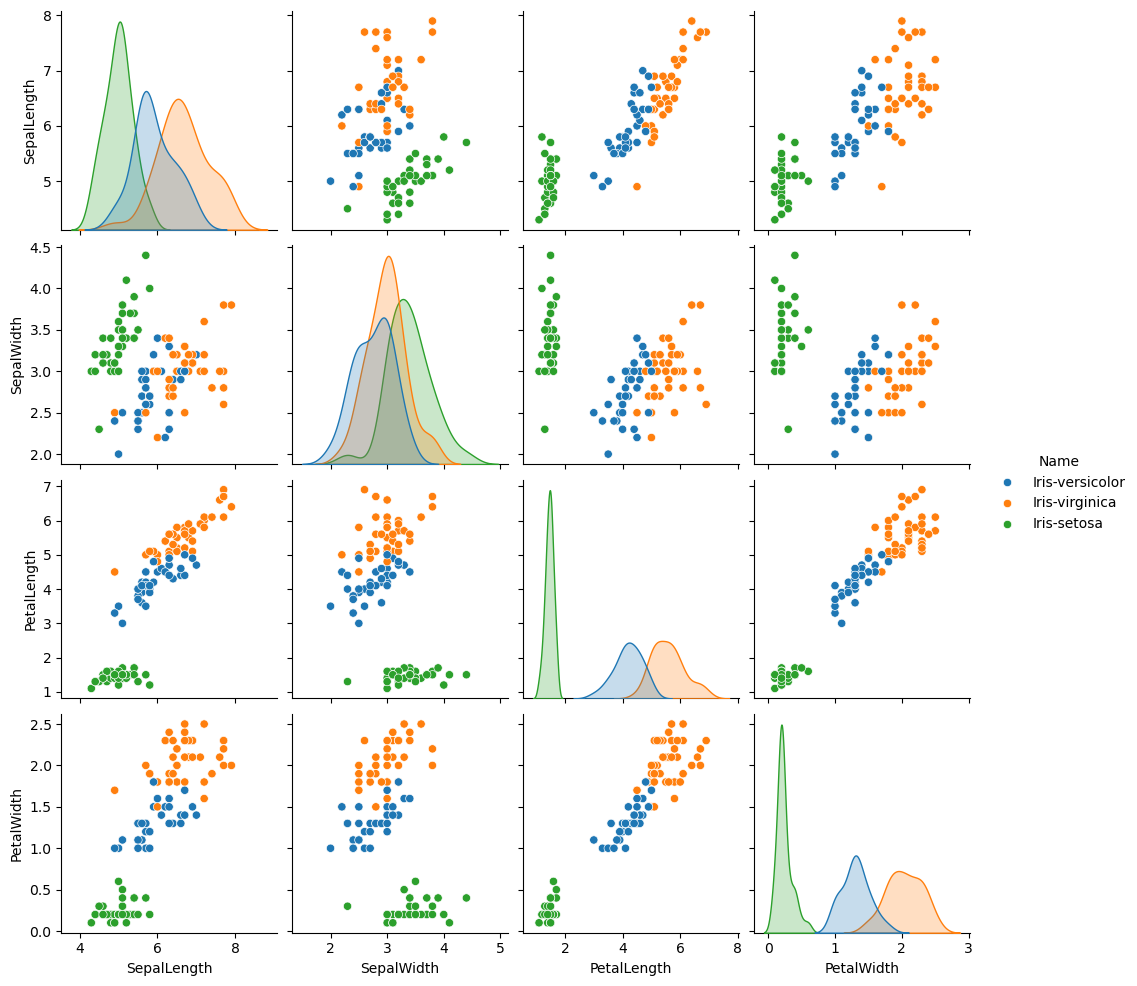

In [275]:
_ = sns.pairplot(pd.concat([X_train,y_train],  axis=1), hue='Name')

# Apply PCA for visualisation

In [276]:
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=2).fit_transform(X_train)
X_reduced

array([[ 0.45187781, -0.12653065],
       [ 0.16262372, -0.43124991],
       [ 2.11302025,  0.14903646],
       [-2.94915491, -0.08909834],
       [ 1.87550199,  0.34566969],
       [-2.45689132,  0.2387755 ],
       [-2.54860646,  0.68844055],
       [-0.59622999, -1.27602782],
       [ 1.89217608, -0.01529669],
       [ 2.36959994,  0.24578938],
       [ 1.22354503, -0.81632589],
       [ 2.25598995, -0.32364694],
       [-0.02711466, -0.60548389],
       [ 3.03444653,  0.58449273],
       [ 1.04409878,  0.24964609],
       [-0.14323831, -0.72494015],
       [ 1.32609375, -0.25580936],
       [ 1.38177401, -0.19436823],
       [ 0.43593922, -1.19894582],
       [ 1.46045568, -0.43299739],
       [ 1.24227897,  0.62616403],
       [ 1.70876946,  0.0249105 ],
       [ 0.75430323,  0.1749512 ],
       [-2.64952484, -0.15769125],
       [ 1.34409438, -0.61241014],
       [ 0.28691348, -0.52510663],
       [-0.23706352, -0.2631179 ],
       [ 0.09230774, -0.70161771],
       [ 0.83165837,

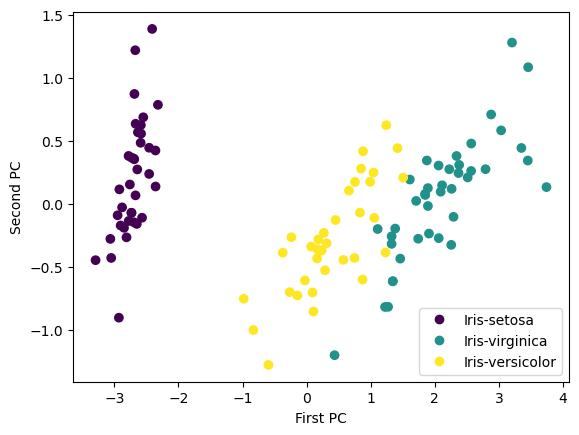

In [277]:
ax = plt.figure().add_subplot()


colors = y_train['Name'].map({name: i for i, name in enumerate(set(y_train['Name']))})
scatter = ax.scatter(X_reduced[:,0], X_reduced[:,1], c=colors)
ax.set_xlabel('First PC')
ax.set_ylabel('Second PC')

ax.legend(scatter.legend_elements()[0], list(set(df.Name)))

# Logistic, LDA & QDA

## Naive fit

In [278]:
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression

In [279]:
models = [LogisticRegression(max_iter=1000), LDA(store_covariance=True), QDA(store_covariance=True)]
fitted_models = []
prediction_errors = []
for model in models:
    result = model.fit(X_train, y_train['Name'])
    fitted_models.append(result)

    predictions = result.predict(X_test)
    error_rate  = np.mean(predictions != y_test['Name']) * 100
    prediction_errors.append(error_rate)
  
    

In [280]:
model_names = ['Logistic Regression', 'LDA', 'QDA']
errors = pd.DataFrame({'Model': model_names, 'Error rate (test set)' : prediction_errors})
errors.set_index('Model', inplace=True)
print(errors)

                     Error rate (test set)
Model                                     
Logistic Regression               2.631579
LDA                               2.631579
QDA                               2.631579


# Cross validation approach

In [281]:
from sklearn.model_selection import cross_val_score

In [282]:
models = [LogisticRegression(max_iter=1000), LDA(store_covariance=True), QDA(store_covariance=True)]
scores = []
for model in models:
    rate = cross_val_score(model, X_train, y_train['Name'], cv=5)
    scores.append(np.mean(rate)*100)

accuracy_CV = pd.DataFrame({'Model' : model_names, 'Accuracy rate (CV)': scores}).set_index('Model')

In [283]:
print('Accuracy in CV\n')
print(accuracy_CV)

Accuracy in CV

                     Accuracy rate (CV)
Model                                  
Logistic Regression           96.403162
LDA                           98.221344
QDA                           97.312253


Based on results, fit LDA to whole data and test on test set

In [284]:
lda = LDA(store_covariance=True)
results = lda.fit(X_train, y_train['Name'])

predictions = results.predict(X_test)
error_rate = np.mean(predictions != y_test['Name'])
print(f'Error rate for LDA on test set: {error_rate * 100 : .2f}%')

Error rate for LDA on test set:  2.63%


# RandomForest

In [292]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rate = cross_val_score(rfc, X_train, y_train['Name'], cv=5)
print(f'Accuracy of Random Forest (CV) = {np.mean(rate)*100:.2f}%')

Accuracy of Random Forest (CV) = 95.53%


In [286]:
# Tune n_estimators parameter

n_range = range(1, 1000, 100)
prediction_rates = []
for n in n_range:
    rfc = RandomForestClassifier(n_estimators=n)
    rate = cross_val_score(rfc, X_train, y_train['Name'], cv=5)
    prediction_rates.append(np.mean(rate))

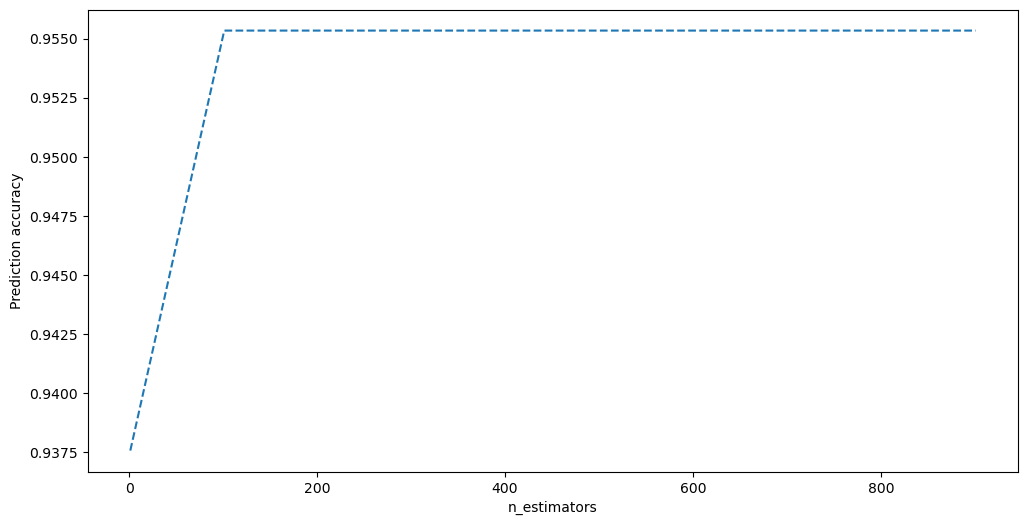

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(n_range, prediction_rates, '--')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Prediction accuracy')
plt.show()

## Single Tree Regressor

In [288]:
from sklearn.tree import (DecisionTreeClassifier as DTC, plot_tree)

dtc = DTC()
rate = cross_val_score(dtc, X_train, y_train['Name'], cv=5)
print(f'Prediction rate for single tree: {rate.mean()*100:.2f}%')


Prediction rate for single tree: 96.40%


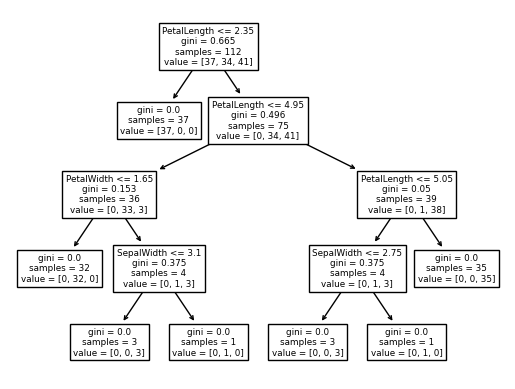

In [289]:
#Visualise tree
dtc.fit(X_train, y_train)
plot_tree(dtc,
         feature_names=X.columns);

In [293]:
# Prune tree
from sklearn.model_selection import GridSearchCV
ccp_path = dtc.cost_complexity_pruning_path(X_train, y_train['Name'])
results = GridSearchCV(dtc,
                       {'ccp_alpha': ccp_path.ccp_alphas},
                       refit=True,
                       scoring='accuracy'
                      )
results.fit(X_train, y_train['Name'])


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00869963, 0.01339286, 0.03571429, 0.26539835,
       0.33279549])},
             scoring='accuracy')

In [294]:
best_tree = results.best_estimator_
scores = cross_val_score(best_tree, X_train, y_train, cv=5)
avg_accuracy = scores.mean()
print(f'Accuracy of pruned tree (CV): {avg_accuracy * 100 : .2f}%')

Accuracy of pruned tree (CV):  94.66%


# Final model
Based on CV scores, we choose LDA